In [14]:
import numpy as np
import MGrowth as mg
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times']})
import seaborn as sns
palette = sns.color_palette('Dark2') 
colors = palette  
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 28
VERY_SMALL= 14
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)
plt.rc('legend', fontsize=VERY_SMALL)

# Binned $\mu$ with cubic-spline
In this notebook we demonstrate examples of using $\mu$-interpolators. First we take an nDGP cosmology with $\Omega_{\rm m}=0.3$ and $\Omega_{rc}=0.25$ and fit a binned-$\mu$ approach to it, inspired by the following paper https://arxiv.org/abs/2107.12992 .

In [16]:
# Constants
omega0 = 0.3
omegarc = 0.25

nnode = 10
zstart, ztanh = 3.0, 4.0
astart, atanh, aend = 1.0 / (1.0 + zstart), 1.0 / (1.0 + ztanh), 1.0
# Arrays
a_arr = np.zeros(2 * nnode, dtype=np.float64)
mu_arr = np.zeros(2 * nnode, dtype=np.float64)
for i in range(1, nnode + 1):
        a_arr[i - 1] = atanh * float(i - 1) / float(nnode - 1)
        a_arr[nnode + i - 1] = astart + (1.0 - astart) * float(i - 1) / float(nnode - 1)
a_arr[0]=1e-3

aa = np.linspace(1e-3, 1, 256)

In [11]:
def Omega_m(a, omega0=0.3, w0=-1, wa=0):
    omegaL = (1.-omega0) * a**(-3.*(1.+w0+wa)) * np.exp(3.*(-1.+a)*wa)
    E2 = omega0/a**3 + omegaL
    return omega0/a**3/E2

def dlnH_dlna(a, omega0=0.3, w0=-1, wa=0):
    omegaL = (1.-omega0) * a**(-3.*(1.+w0+wa)) * np.exp(3.*(-1.+a)*wa)
    E2 = omega0/a**3 + omegaL
    return  -1.5 * (omega0/a**3 + (1+w0+wa*(1.-a))*omegaL)/E2


def mu_nDGP(a, omega0, omegarc, w0=-1, wa=0.):
    omegaL = (1.-omega0) * a**(-3.*(1.+w0+wa)) * np.exp(3.*(-1.+a)*wa)
    E = np.sqrt(omega0/a**3 + omegaL)
    beta =  1. + E/np.sqrt(omegarc)  * (1. + 1./3 * dlnH_dlna(a, omega0, w0, wa))
    mu_nDGP = 1. + 1./(3.*beta)
    return mu_nDGP

def mu_recon(a, mu11):
    for i in range(nnode+1):
        mu_arr[nnode-1+i]=mu11[i]
    for j in range(nnode-1):
        mu_arr[j] = (mu_arr[nnode-1] - 1.0) / 2.0 * (1.0 + np.tanh((a_arr[j] - atanh / 2.0) / 0.04)) + 1.0
    # Spline interpolation
    spline_mu = CubicSpline(a_arr, mu_arr)
    return(spline_mu(a))

def mu_extrap(mu11):
    for i in range(nnode+1):
        mu_arr[nnode-1+i]=mu11[i]
    for i in range(1, nnode + 1):
        if i < nnode:
            mu_arr[i - 1] = (mu_arr[nnode-1] - 1.0) / 2.0 * (1.0 + np.tanh((a_arr[i - 1] - atanh / 2.0) / 0.04)) + 1.0
    return(mu_arr[:9])

In [12]:
spline_mu_nDGP = CubicSpline(aa, mu_nDGP(aa, omega0, omegarc, w0=-1, wa=0.))
mu_binned_nDGP = spline_mu_nDGP(a_arr[-11:])

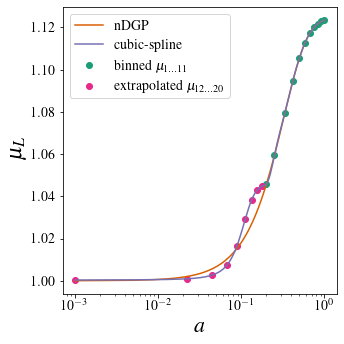

In [15]:
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w')
ax.scatter(a_arr[-11:], mu_binned_nDGP, color=colors[0], label='binned $\mu_{1...11}$')
ax.scatter(a_arr[:9], mu_extrap(mu_binned_nDGP), color=colors[3], label='extrapolated $\mu_{12...20}$')
ax.semilogx(aa, mu_nDGP(aa, omega0, 0.25), color=colors[1],label='nDGP')
ax.semilogx(aa, mu_recon(aa, mu_binned_nDGP), color=colors[2], label='cubic-spline')
ax.set_xlabel('$a$')
ax.set_ylabel('$\mu_{L}$')
ax.legend(loc='upper left', title_fontsize=16)
plt.tight_layout()
plt.show()

After comparing the modification of the gravitational constant we now compare the resulting growth factor and growth rate. We compute them via nDGP- and mu(a)-options in MGrowth.  

In [17]:
background ={'Omega_m':omega0,
            'h' : 0.68,
            'w0': -1.,
            'wa': 0.,
            'a_arr': aa}
cosmo1 = mg.mu_a(background) 
mu_all = mu_recon(aa, mu_binned_nDGP)
mu_interpolator = interp1d(aa, mu_all, bounds_error=False,
                kind='cubic',
                fill_value=(mu_all[0], mu_all[-1])) 
Da1, fa1 = cosmo1.growth_parameters(mu_interp=mu_interpolator)
Dz1_g, fz1_g = Da1[::-1], fa1[::-1]  

cosmo2 = mg.nDGP(background)
Da2, fa2 = cosmo2.growth_parameters(omegarc=0.25)
Dz2_g, fz2_g = Da2[::-1], fa2[::-1] 

cosmo3 = mg.mu_a(background) 
mu_ndgp = mu_nDGP(aa, omega0, omegarc)
mu_ndgp_interpolator = interp1d(aa, mu_ndgp, bounds_error=False,
                kind='cubic',
                fill_value=(mu_ndgp[0], mu_ndgp[-1])) 
Da3, fa3 = cosmo3.growth_parameters(mu_interp=mu_ndgp_interpolator)
Dz3_g, fz3_g = Da3[::-1], fa3[::-1]                  

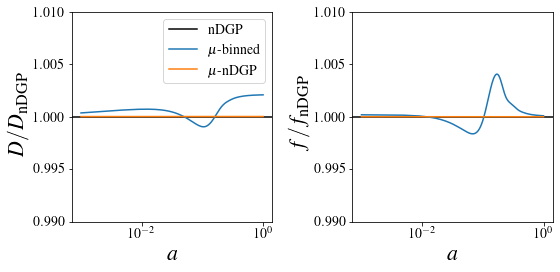

In [19]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, facecolor='w')
ax[0].axhline(y=1, color='k', label='nDGP')
ax[1].axhline(y=1, color='k')
ax[0].semilogx(aa, Da1/Da2, label='$\mu$-binned')
ax[1].semilogx(aa, fa1/fa2)
ax[0].semilogx(aa, Da3/Da2, label='$\mu$-nDGP')
ax[1].semilogx(aa, fa3/fa2)
ax[0].set_xlabel('$a$')
ax[1].set_xlabel('$a$')
ax[0].set_ylabel('$D/D_{\\rm nDGP}$')
ax[1].set_ylabel('$f/f_{\\rm nDGP}$')
ax[0].legend(loc='upper right', title_fontsize=16)
ax[0].set_ylim(0.99, 1.01)
ax[1].set_ylim(0.99, 1.01)
plt.tight_layout()
plt.show()

# Dark energy parametrisation $\mu(a)=1+\mu_0\frac{\Omega_{\Lambda}(a)}{\Omega_{\Lambda}(1)}$

In [20]:
def mu_DE(a, omega0, mu0, w0=-1, wa=0.):
    omegaL = (1.-omega0) * a**(-3.*(1.+w0+wa)) * np.exp(3.*(-1.+a)*wa)
    omegaL0 = (1.-omega0) 
    E = np.sqrt(omega0/a**3 + omegaL)
    mu_DE = 1. + mu0*(omegaL/E**2)/omegaL0
    return mu_DE

In [21]:
mu0 = 0.5
background ={'Omega_m':omega0,
            'h' : 0.68,
            'w0': -1.,
            'wa': 0.,
            'a_arr': aa}
cosmo = mg.mu_a(background) 
mu_de = mu_DE(aa, omega0, mu0)
mu_interpolator = interp1d(aa, mu_de, bounds_error=False,
                kind='cubic',
                fill_value=(mu_de[0], mu_de[-1])) 
Da, fa = cosmo.growth_parameters(mu_interp=mu_interpolator)
Dz_g, fz_g = Da[::-1], fa[::-1]  

cosmo_lcdm = mg.LCDM(background) 
Da_lcdm, fa_lcdm = cosmo_lcdm.growth_parameters()
Dz_lcdm, fz_lcdm = Da_lcdm[::-1], fa_lcdm[::-1]

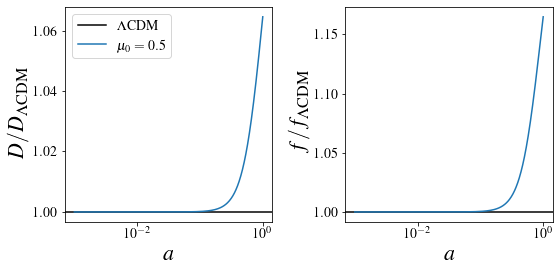

In [23]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, facecolor='w')
ax[0].axhline(y=1, color='k', label='$\\Lambda$CDM')
ax[1].axhline(y=1, color='k')
ax[0].semilogx(aa, Da/Da_lcdm, label='$\mu_0=0.5$')
ax[1].semilogx(aa, fa/fa_lcdm)
ax[0].set_xlabel('$a$')
ax[1].set_xlabel('$a$')
ax[0].set_ylabel('$D/D_{\\Lambda \\rm CDM}$')
ax[1].set_ylabel('$f/f_{\\Lambda \\rm CDM}$')
ax[0].legend(loc='upper left', title_fontsize=16)
plt.tight_layout()
plt.show()

# Scale-dependent $\mu$: $\mu(a, k)=\frac{1+p_1(a)k^2}{p_2(a) + p_3(a) k^2}$

In [ ]:
# example with p1=mu0*omegaL(a)/OmegaL0, i.e. DE-paraqmetrisation; p2=1, p3=0
# k = k_/(1 h/Mpc) 
def mu_a_k(a, omega0, mu0, k, w0=-1, wa=0.):
    omegaL = (1.-omega0) * a**(-3.*(1.+w0+wa)) * np.exp(3.*(-1.+a)*wa)
    omegaL0 = (1.-omega0) 
    E = np.sqrt(omega0/a**3 + omegaL)
    mu_DE_k = 1. + mu0*(omegaL/E**2)/omegaL0*k**2
    return mu_DE_k

In [27]:
k_arr = np.logspace(-2, 1, 50)
mu0 = 0.5
background ={'Omega_m':omega0,
            'h' : 0.68,
            'w0': -1.,
            'wa': 0.,
            'a_arr': aa}
cosmo = mg.mu_a(background) 
mu_de_k = np.array([mu_a_k(aa, omega0, mu0, k_i) for k_i in k_arr])
mu_interpolator_k = np.array([interp1d(aa, mu_de_k_i, bounds_error=False,
                kind='cubic',
                fill_value=(mu_de_k_i[0], mu_de_k_i[-1])) for mu_de_k_i in mu_de_k]) 
D_f_i = np.array([cosmo.growth_parameters(mu_interp=mu_interpolator_k_i) for mu_interpolator_k_i in mu_interpolator_k])

D = np.array([D_i for D_i, _ in D_f_i])
f = np.array([f_i for _, f_i in D_f_i])
print('shape of D_f_i: ', D_f_i.shape)
print('shape of D: ', D.shape)
print('shape of f: ', f.shape)

shape of D_f_i:  (50, 2, 256)
shape of D:  (50, 256)
shape of f:  (50, 256)


/Users/s2265800/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


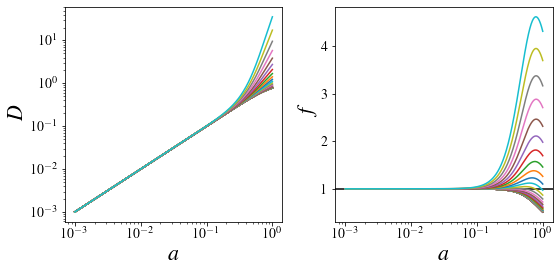

In [34]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, facecolor='w')
ax[0].axhline(y=0, color='k')
ax[1].axhline(y=1, color='k')
for i in range(len(k_arr)):
    ax[0].loglog(aa, D[i, :])
    ax[1].semilogx(aa, f[i, :])
ax[0].set_xlabel('$a$')
ax[1].set_xlabel('$a$')
ax[0].set_ylabel('$D$')
ax[1].set_ylabel('$f$')
plt.tight_layout()
plt.show()